In [1]:
import os
import re
import random
from argparse import Namespace

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import wandb

from tqdm import tqdm
import torchaudio
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from fairseq.data import Dictionary
from fairseq.models.mST.w2v2_phone_transformer import W2V2Transformer
from fairseq.data.audio.multilingual_triplet_v2_phone_dataset import (
    MultilingualTripletDataConfig,
    MultilingualTripletDataset,
    MultilingualTripletDatasetCreator
)
from fairseq.data.audio.speech_to_text_dataset import get_features_or_waveform
from examples.speech_to_text.data_utils import load_df_from_tsv
from fairseq.checkpoint_utils import load_checkpoint_to_cpu
from fairseq.data.encoders.sentencepiece_bpe import SentencepieceBPE, SentencepieceConfig

In [2]:
sns.set(font="Noto Sans CJK JP")

In [4]:
device = 'cuda:7'

# Load checkpoints

In [5]:
args = Namespace()
task = Namespace()

In [6]:
def load_dict(vocab_filename):
    _dict_path = vocab_filename
    if not os.path.isfile(_dict_path):
        raise FileNotFoundError(f"Dict not found: {_dict_path}")
    _dict = Dictionary.load(_dict_path)
    for code in codes:
        _dict.add_symbol(MultilingualTripletDataset.LANG_TAG_TEMPLATE.format(code))
    _dict.add_symbol('<mask>')
    return _dict

In [7]:
lang_list_filename = '/mnt/raid5/siqi/checkpoints/pretrained/mbart50.ft.n1/ML50_langs.txt'
vocab_filename = '/mnt/raid5/siqi/checkpoints/pretrained/mbart50.ft.n1/dict.txt'
phone_vocab_filename = '/mnt/raid5/siqi/datasets/covost2/phone_dict.txt'

In [8]:
codes = MultilingualTripletDataset.get_lang_codes(lang_list_filename)
dict = load_dict(vocab_filename)
with open(phone_vocab_filename, 'r') as r:
    phone_list = [l.strip() for l in r.readlines() if l.strip() != '']
    phone_dict = {l: idx + 1 for idx, l in enumerate(phone_list)} # leave 0 as blank
    phone_list = ['|'] + phone_list

In [9]:
task.src_dict = task.tgt_dict = dict
task.phone_dict = phone_dict

In [10]:
args.w2v2_model_path = '/mnt/raid5/siqi/checkpoints/pretrained/xlsr2_300m.pt'
args.mbart50_dir = '/mnt/raid5/siqi/checkpoints/pretrained/mbart50.ft.n1'

In [11]:
model = W2V2Transformer.build_model(args, task)

In [108]:
ckpt_path_1 = '/mnt/raid5/siqi/checkpoints/xlsr_phone_mbart_de_zh_ctc_text/checkpoint_best.pt'
ckpt_path_2 = '/mnt/raid5/siqi/checkpoints/xlsr_phone_mbart_zh_ctc_text/checkpoint_best.pt'
ckpt_path_3 = '/mnt/raid5/siqi/checkpoints/xlsr_phone_mbart_de_zh/checkpoint_best.pt'
ckpt_path_4 = '/mnt/raid5/siqi/checkpoints/xlsr_mbart_n1/checkpoint_best.pt'
# ckpt_path = '/mnt/raid5/siqi/checkpoints/xlsr_mbart_n1/checkpoint_best.pt'
ckpt_1 = load_checkpoint_to_cpu(ckpt_path_1)
ckpt_2 = load_checkpoint_to_cpu(ckpt_path_2)
ckpt_3 = load_checkpoint_to_cpu(ckpt_path_3)
ckpt_4 = load_checkpoint_to_cpu(ckpt_path_4)

In [109]:
model.load_state_dict(ckpt_4["model"], strict=False)
model = model.to(device)
model.eval()

W2V2Transformer(
  (encoder): W2V2PhoneTransformerEncoder(
    (w2v2_model): Wav2Vec2Model(
      (feature_extractor): ConvFeatureExtractionModel(
        (conv_layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
            (1): Dropout(p=0.0, inplace=False)
            (2): Sequential(
              (0): TransposeLast()
              (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (2): TransposeLast()
            )
            (3): GELU()
          )
          (1): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
            (1): Dropout(p=0.0, inplace=False)
            (2): Sequential(
              (0): TransposeLast()
              (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (2): TransposeLast()
            )
            (3): GELU()
          )
          (2): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,

# Prepare parallel De and Zh data

In [3]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model = AutoModelForSeq2SeqLM.from_pretrained("facebook/wmt21-dense-24-wide-en-x").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/wmt21-dense-24-wide-en-x")

In [13]:
test_st_de_en = load_df_from_tsv('/mnt/raid5/siqi/datasets/covost2/de/test_st_de_en.tsv')
en_ref = test_st_de_en['tgt_text'].tolist()

In [6]:
batch_size = 20
zh_text = []
for idx in tqdm(range(0, len(en_ref), batch_size)):
    inputs = tokenizer(en_ref[idx : idx + batch_size], return_tensors='pt', padding=True).to(device)
    generated_tokens = model.generate(**inputs, forced_bos_token_id=tokenizer.get_lang_id("zh"))
    zh_text.extend(tokenizer.batch_decode(generated_tokens, skip_special_tokens=True))

100%|██████████| 676/676 [15:28<00:00,  1.37s/it]


In [7]:
np.save('resources/zh_text.npy', zh_text)

In [14]:
zh_text = np.load('resources/zh_text.npy')

# Generate parallel audio

In [1]:
import soundfile as sf
import numpy as np

import tensorflow as tf

from tensorflow_tts.inference import AutoProcessor
from tensorflow_tts.inference import TFAutoModel

processor = AutoProcessor.from_pretrained("tensorspeech/tts-tacotron2-baker-ch")
tacotron2 = TFAutoModel.from_pretrained("tensorspeech/tts-tacotron2-baker-ch")
mb_melgan = TFAutoModel.from_pretrained("tensorspeech/tts-mb_melgan-baker-ch")


/mnt/nvme/siqi/anaconda3/envs/tts/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: 100%|██████████| 14.3k/14.3k [00:00<00:00, 11.7MB/s]
Downloading: 100%|██████████| 129M/129M [00:03<00:00, 35.5MB/s] 
Downloading: 100%|██████████| 4.01k/4.01k [00:00<00:00, 2.56MB/s]
2022-04-26 03:22:23.293513: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-04-26 03:22:23.293546: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setu

In [15]:
n_sample = 100

In [2]:
text = "这是一个开源的端到端中文语音合成系统"

input_ids = processor.text_to_sequence(text, inference=True)

# tacotron2 inference (text-to-mel)
decoder_output, mel_outputs, stop_token_prediction, alignment_history = tacotron2.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    input_lengths=tf.convert_to_tensor([len(input_ids)], tf.int32),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
)

# melgan inference (mel-to-wav)
audio = mb_melgan.inference(mel_outputs)[0, :, 0]

# save to file
sf.write('./test.wav', audio, 16000, "PCM_16")

phoneme seq: sil zh e4 #0 sh iii4 #0 ^ i2 #0 g e4 #0 k ai1 #0 ^ van2 #0 d e5 #0 d uan1 #0 d ao4 #0 d uan1 #0 zh ong1 #0 ^ uen2 #0 ^ v3 #0 ^ in1 #0 h e2 #0 ch eng2 #0 x i4 #0 t ong3 sil


In [6]:
from gtts import gTTS
for zh_utt, id in zip(tqdm(results[:n_sample]), test_st_de_en['id']):
    tts = gTTS(zh_utt, lang='zh')
    tts.save('/mnt/raid5/siqi/datasets/covost2/de/16kHz_zh/{}.mp3'.format(id))

In [8]:
# resample
for id in tqdm(test_st_de_en['id'][:n_sample]):
    path = '/mnt/raid5/siqi/datasets/covost2/de/16kHz_zh/{}.mp3'.format(id)
    wave = torchaudio.load(path)[0]
    torchaudio.save('/mnt/raid5/siqi/datasets/covost2/de/16kHz_zh/{}.wav'.format(id), wave, sample_rate=16000)

100%|██████████| 100/100 [00:00<00:00, 170.93it/s]


In [16]:
de_audios = []
for audio in test_st_de_en['audio']:
    de_audios.append(os.path.join('/mnt/raid5/siqi/datasets/covost2/de/16kHz', audio))
zh_audios = []
for audio in test_st_de_en['audio'][:n_sample]:
    zh_audios.append(os.path.join('/mnt/raid5/siqi/datasets/covost2/de/16kHz_zh', audio))

In [17]:
neg_de_audios = []
for audio in test_st_de_en['audio'][-n_sample:]:
    neg_de_audios.append(os.path.join('/mnt/raid5/siqi/datasets/covost2/de/16kHz', audio))

# Inference

In [19]:
def compute(path):
    source = get_features_or_waveform(
        path,
        need_waveform=True,
        sample_rate=16000,
    )
    source = th.from_numpy(source).float()
    src_tokens = source.unsqueeze(0).to(device)
    src_lengths = th.LongTensor([source.size(0)]).to(device)
    speech_encoder_out = model.encoder.forward_speech(src_tokens, src_lengths)
    return speech_encoder_out

In [19]:
de_ft_per_layer = [[] for _ in range(24)]
zh_ft_per_layer = [[] for _ in range(24)]
neg_de_ft_per_layer = [[] for _ in range(24)]
with th.no_grad():
    for de_audio, zh_audio, neg_de_audio in zip(de_audios, tqdm(zh_audios), neg_de_audios):
        de_res = compute(de_audio)
        zh_res = compute(zh_audio)
        neg_de_res = compute(neg_de_audio)
        for idx in range(24):
            de_ft_per_layer[idx].append(de_res['layer_results'][idx].squeeze().amax(dim=0))
            zh_ft_per_layer[idx].append(zh_res['layer_results'][idx].squeeze().amax(dim=0))
            neg_de_ft_per_layer[idx].append(neg_de_res['layer_results'][idx].squeeze().amax(dim=0))

100%|██████████| 100/100 [00:11<00:00,  8.85it/s]


In [20]:
dist_per_layer = []
neg_dist_per_layer = []
for layer_idx in range(24):
    dists = []
    neg_dists = []
    for ex_idx in range(n_sample):
        l2_dist = (de_ft_per_layer[layer_idx][ex_idx] - zh_ft_per_layer[layer_idx][ex_idx]).norm() / zh_ft_per_layer[layer_idx][ex_idx].norm()
        neg_l2_dist = (neg_de_ft_per_layer[layer_idx][ex_idx] - zh_ft_per_layer[layer_idx][ex_idx]).norm() / zh_ft_per_layer[layer_idx][ex_idx].norm()
        # cos_dist = F.cosine_similarity(de_ft_per_layer[layer_idx][ex_idx], zh_ft_per_layer[layer_idx][ex_idx], dim=0)
        # neg_cos_dist = F.cosine_similarity(neg_de_ft_per_layer[layer_idx][ex_idx], zh_ft_per_layer[layer_idx][ex_idx], dim=0)
        dists.append(l2_dist.item())
        neg_dists.append(neg_l2_dist.item())
    dist_per_layer.append(dists)
    neg_dist_per_layer.append(neg_dists)

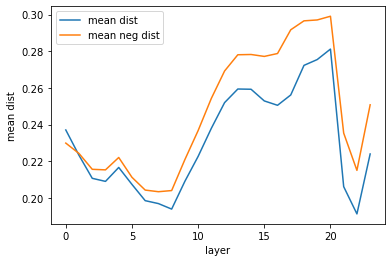

In [27]:
avg_dist_per_layer = []
avg_neg_dist_per_layer = []
for layer_idx in range(24):
    avg_dist = sum(dist_per_layer[layer_idx]) / n_sample
    avg_neg_dist = sum(neg_dist_per_layer[layer_idx]) / n_sample
    avg_dist_per_layer.append(avg_dist)
    avg_neg_dist_per_layer.append(avg_neg_dist)
plt.plot(avg_dist_per_layer, label='mean dist')
plt.plot(avg_neg_dist_per_layer, label='mean neg dist')
plt.xlabel('layer')
plt.ylabel('mean dist')
plt.legend()

In [120]:
sns_df = pd.DataFrame(columns=['dist', 'neg_dist', 'layer'])
dists = []
neg_dists = []
for idx in range(0, 24, 4):
    dists.extend(dist_per_layer[idx])
    neg_dists.extend(neg_dist_per_layer[idx])
sns_df['dist'] = dists
sns_df['neg_dist'] = neg_dists
layer_indices = [idx for idx in range(0, 24, 4) for _ in range(n_sample)]
sns_df['layer'] = layer_indices

(0.0, 200.0)

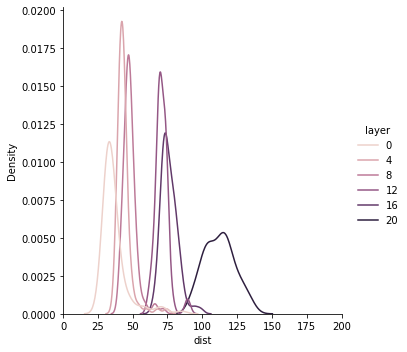

In [121]:
sns.displot(sns_df, x='dist', hue='layer', kind='kde')
plt.xlim(0, 200)

(0.0, 200.0)

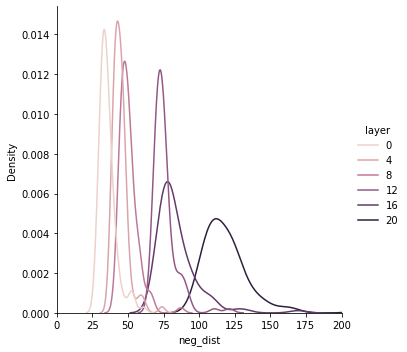

In [122]:
sns.displot(sns_df, x='neg_dist', hue='layer', kind='kde')
plt.xlim(0, 200)

# Audio retrieve test

In [22]:
full_de_ft_per_layer = [[] for _ in range(24)]
with th.no_grad():
    for de_audio in tqdm(de_audios):
        de_res = compute(de_audio)
        for idx in range(24):
            full_de_ft_per_layer[idx].append(de_res['layer_results'][idx].squeeze().amax(dim=0).cpu())

100%|██████████| 13511/13511 [08:18<00:00, 27.11it/s]


In [23]:
for layer_idx in range(24):
    full_de_ft_per_layer[layer_idx] = np.array([t.numpy() for t in full_de_ft_per_layer[layer_idx]])

In [24]:
import faiss

In [25]:
accs = []
for layer_idx in range(24):
    index = faiss.IndexFlatL2(1024)
    index.add(np.array(full_de_ft_per_layer[layer_idx]))
    
    qry = np.array([t.cpu().numpy() for t in zh_ft_per_layer[layer_idx]])
    D, I = index.search(qry, 100)
    acc = sum([idx in I[idx] for idx in range(len(zh_ft_per_layer[layer_idx]))]) / len(zh_ft_per_layer[layer_idx])
    accs.append(acc)

Text(0, 0.5, 'top-100 acc')

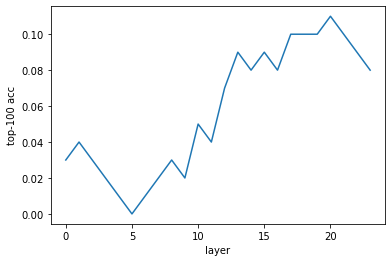

In [28]:
plt.plot(accs)
plt.xlabel('layer')
plt.ylabel('top-100 acc')

In [28]:
for idx in range(n_sample):
    print(zh_text[idx], en_ref[I[idx, 0]])

请在外面脱鞋。 Thank you for the presents.
奥托不想打架,屈服了。 See also the article Avalonia.
现在是格施塔德摊牌的时候了。 The solution clearly reacts basic.
他们的系列照片出现在《Vogue》、《Harper's Bazaar》和《Marie Claire》等时尚杂志上。 Waits composed the soundtrack for this movie together with Crystal Gayle.
"那又怎么样,我已经准备好了。 See also the article Avalonia.
互联网由许多相互连接的计算机组成。 Hence, the position of the submarine could be deduced relatively well.
天王星是我们太阳系中的第七颗行星。 It was built according to plans by architect Paul Hoppe.
总的来说,声音有点低沉。 See also the article Avalonia.
目前的交通状况如何? See also the article Avalonia.
该措施以英寸为单位。 Thank you for the presents.
礼宾府的很大一部分现在用于巴黎法院。 Wilke in Rottach-Egern, Upper Bavaria on Lake Tegernsee.
你为什么想去伯格海姆? See also the article Avalonia.
竞赛的编辑。 Don’t annoy me.
她从八岁开始接受舞蹈课。 It was succeeded by VfB Oldenburg.
内部有一个平坦的木制天花板;画廊已经安装在北墙和西墙上。 It can be risk factors as well as parameters in chemical reactions.
四年后,他的父亲在打猎时遭遇意外,导致他无法工作。 The venue was the dynamo shooting range in the suburb of Mytischtschi.
我本不会让你通过的。 Thank yo

# CER comparison of De+Zh and Zh

In [29]:
with open(lang_list_filename, 'r') as r:
    lang_codes = [line.strip() for line in r.readlines() if line.strip() != ""]
lang2langcode = {code[:2] : code for code in lang_codes}

In [30]:
spm_config = SentencepieceConfig(sentencepiece_model='/mnt/raid0/siqi/checkpoints/pretrained/mbart50.ft.n1/sentence.bpe.model')
spm = SentencepieceBPE(spm_config)

In [31]:
data_root = '/mnt/raid5/siqi/datasets/covost2'

In [67]:
import editdistance

In [72]:
df = load_df_from_tsv('/mnt/raid5/siqi/datasets/covost2/zh-CN/dev_st_zh-CN_en_phone.tsv')

In [86]:
with th.no_grad():
    preds = []
    refs = df['src_text'].tolist()
    cers = []
    for idx in tqdm(range(len(df))):
        source = get_features_or_waveform(
            os.path.join(data_root, 'zh-CN', '16kHz', df.iloc[idx]['audio']),
            need_waveform=True,
            sample_rate=16000,
        )
        source = th.from_numpy(source).float()

        lang_tag = "<lang:{}>".format(lang2langcode['zh'])
        src_lang_tag_idx = dict.index(lang_tag)

        src_tokens = source.unsqueeze(0).to(device)
        src_lengths = th.LongTensor([source.size(0)]).to(device)
        src_lang_tag_indices = th.LongTensor([src_lang_tag_idx]).unsqueeze(-1).to(device)

        encoder_out = model.forward_encoder(src_tokens, src_lengths, src_lang_tag_indices=src_lang_tag_indices)

        pred = spm.decode(' '.join([dict[tok] for tok in encoder_out.text_logp.argmax(dim=-1).squeeze().unique_consecutive() if dict[tok] not in ['<mask>', '<lang:zh_CN>', '</s>']]))
        # print(spm.encode(df.iloc[idx]['src_text']))
        ref = df.iloc[idx]['src_text']

        cer = editdistance.eval(pred, ref) / len(ref)

        preds.append(pred)
        cers.append(cer)
preds = np.array(preds)
cers = np.array(cers)

100%|██████████| 4843/4843 [05:24<00:00, 14.93it/s]


In [89]:
zh_preds = preds
zh_cers = cers

In [85]:
de_zh_preds = preds
de_zh_cers = cers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


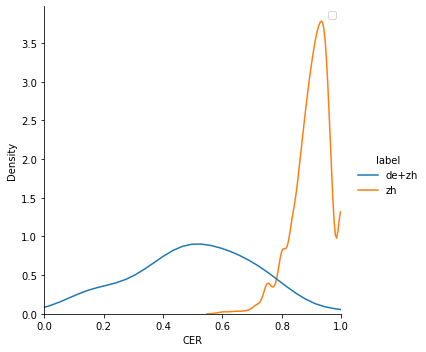

In [94]:
sns_df = pd.DataFrame(columns=['cer', 'label'])
sns_df['cer'] = np.concatenate([de_zh_cers, zh_cers])
sns_df['label'] = ['de+zh'] * len(de_zh_cers) + ['zh'] * len(zh_cers)
sns.displot(sns_df, x='cer', hue='label', kind='kde')
plt.xlabel('CER')
plt.xlim(0, 1)

In [ ]:
dev_zh_preds = zh_preds
dev_zh_cers = zh_cers
dev_de_zh_preds = de_zh_preds
dev_de_zh_cers = de_zh_cers

# POS on features produced by De+Zh and Zh for each layer

## Produce audio features

In [15]:
train_st_zh_en = load_df_from_tsv('/mnt/raid5/siqi/datasets/covost2/zh-CN/train_st_zh-CN_en.tsv')
dev_st_zh_en = load_df_from_tsv('/mnt/raid5/siqi/datasets/covost2/zh-CN/dev_st_zh-CN_en.tsv')
test_st_zh_en = load_df_from_tsv('/mnt/raid5/siqi/datasets/covost2/zh-CN/test_st_zh-CN_en.tsv')

In [16]:
train_zh_audios = []
for audio in train_st_zh_en['audio']:
    train_zh_audios.append(os.path.join('/mnt/raid5/siqi/datasets/covost2/zh-CN/16kHz', audio))
dev_zh_audios = []
for audio in dev_st_zh_en['audio']:
    dev_zh_audios.append(os.path.join('/mnt/raid5/siqi/datasets/covost2/zh-CN/16kHz', audio))
test_zh_audios = []
for audio in test_st_zh_en['audio']:
    test_zh_audios.append(os.path.join('/mnt/raid5/siqi/datasets/covost2/zh-CN/16kHz', audio))

In [35]:
res_dir = '/mnt/raid5/siqi/analysis/zh'

In [36]:
def precompute_ft(audios, n_frames, name, dirname, batch_size=1024):
    ft_per_layer = [[] for _ in range(24)]
    batch_idx = 0
    with th.no_grad():
        sum_len = 0
        for idx, audio in enumerate(tqdm(audios, desc=name)):
            res = compute(audio)
            cur_len = res['layer_results'][0].size(0)

            if sum_len + cur_len > batch_size:
                for layer_idx in range(24):
                    th.save(ft_per_layer[layer_idx], os.path.join(dirname, '{}_layer_{}_batch_{}.pt'.format(name, layer_idx, batch_idx)))
                    ft_per_layer[layer_idx] = []
                batch_idx += 1
                sum_len = 0
            
            for layer_idx in range(24):
                ft_per_layer[layer_idx].append(res['layer_results'][layer_idx].cpu().squeeze(dim=1))
            sum_len += cur_len
        
        if len(ft_per_layer[0]) > 0:
            for layer_idx in range(24):
                th.save(ft_per_layer[layer_idx], os.path.join(dirname, '{}_layer_{}_batch_{}.pt'.format(name, layer_idx, batch_idx)))
                ft_per_layer[layer_idx] = []

In [37]:
precompute_ft(test_zh_audios, test_st_zh_en['n_frames'], 'test', res_dir, batch_size=8192)
precompute_ft(dev_zh_audios, dev_st_zh_en['n_frames'], 'dev', res_dir, batch_size=8192)
precompute_ft(train_zh_audios, train_st_zh_en['n_frames'], 'train', res_dir, batch_size=8192)

train: 100%|██████████| 7085/7085 [07:21<00:00, 16.06it/s]


## Produce POS labels

In [39]:
import spacy
spacy.prefer_gpu(gpu_id=int(device[-1]))
nlp = spacy.load("zh_core_web_trf")

In [47]:
train_zh_text = train_st_zh_en['src_text'].tolist()
dev_zh_text = dev_st_zh_en['src_text'].tolist()
test_zh_text = test_st_zh_en['src_text'].tolist()

In [41]:
def precompute_tag(texts, n_frames, name, dirname):
    tags = []
    for text in tqdm(texts, desc=name):
        cur_tag = []
        for token in nlp(text):
            cur_tag.append(token.tag_)
        tags.append(cur_tag)
    th.save(tags, os.path.join(dirname, '{}_tag.pt'.format(name)))

In [42]:
precompute_tag(train_zh_text, train_st_zh_en['n_frames'], 'train', res_dir)
precompute_tag(dev_zh_text, dev_st_zh_en['n_frames'], 'dev', res_dir)
precompute_tag(test_zh_text, test_st_zh_en['n_frames'], 'test', res_dir)

test: 100%|██████████| 4898/4898 [00:58<00:00, 84.25it/s]


# CTC on POS Tag

In [10]:
# gather tags
train_tags = th.load(os.path.join('/mnt/raid5/siqi/analysis/de_zh', 'train_tag.pt'))
dev_tags = th.load(os.path.join('/mnt/raid5/siqi/analysis/de_zh', 'dev_tag.pt'))
test_tags = th.load(os.path.join('/mnt/raid5/siqi/analysis/de_zh', 'test_tag.pt'))

In [11]:
class POSDdataset:
    def __init__(self, dirname, split, layer, labels):
        self.dirname = dirname
        files = os.listdir(dirname)
        self.batches = {}
        pattern = re.compile('{}\_layer\_{}\_batch\_(\d+)\.pt'.format(split, layer))
        for fn in files:
            res = pattern.match(fn)
            if res is not None:
                batch_idx = int(res.group(1))
                self.batches[batch_idx] = fn
        self.n_batch = len(self.batches)
        cum_idx = 0
        for batch_idx in range(self.n_batch):
            batch_size = len(th.load(os.path.join(dirname, self.batches[batch_idx])))
            self.batches[batch_idx] = (self.batches[batch_idx], labels[cum_idx : cum_idx + batch_size])
            cum_idx += batch_size

    def __getitem__(self, batch_idx):
        fn, labels = self.batches[batch_idx]
        features = th.load(os.path.join(self.dirname, fn))
        return features, labels

    def __len__(self):
        return self.n_batch

In [12]:
zh_data_dir = '/mnt/raid5/siqi/analysis/zh'
zh_train = [POSDdataset(zh_data_dir, 'train', layer, train_tags) for layer in tqdm(range(24))]
zh_dev = [POSDdataset(zh_data_dir, 'dev', layer, dev_tags) for layer in tqdm(range(24))]
zh_test = [POSDdataset(zh_data_dir, 'test', layer, test_tags) for layer in tqdm(range(24))]
th.save([zh_train, zh_dev, zh_test], 'zh_dataset.pt')

100%|██████████| 24/24 [01:51<00:00,  4.66s/it]


In [12]:
de_zh_data_dir = '/mnt/raid5/siqi/analysis/de_zh'
de_zh_train = [POSDdataset(de_zh_data_dir, 'train', layer, train_tags) for layer in tqdm(range(24))]
de_zh_dev = [POSDdataset(de_zh_data_dir, 'dev', layer, dev_tags) for layer in tqdm(range(24))]
de_zh_test = [POSDdataset(de_zh_data_dir, 'test', layer, test_tags) for layer in tqdm(range(24))]
th.save([de_zh_train, de_zh_dev, de_zh_test], 'de_zh_dataset.pt')

100%|██████████| 24/24 [01:39<00:00,  4.13s/it]


In [19]:
zh_train, zh_dev, zh_test = th.load('zh_dataset.pt')
de_zh_train, de_zh_dev, de_zh_test = th.load('de_zh_dataset.pt')

In [13]:
class Predictor(nn.Module):
    def __init__(self, n_class):
        super(Predictor, self).__init__()
        self.linear = nn.Linear(1024, n_class)
    
    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=-1)

In [7]:
import spacy
nlp = spacy.load("zh_core_web_trf")
idx2label = list(nlp.components[1][1].labels)
label2idx = {label : idx for idx, label in enumerate(idx2label)}

In [15]:
def collate(features):
    max_len = max(ft.size(0) for ft in features)
    output = th.zeros(len(features), max_len, 1024)
    for idx, ft in enumerate(features):
        output[idx][:ft.size(0)] = ft
    return output

In [16]:
def convert(features, targets):
    input_lengths = th.tensor([ft.size(0) for ft in features])
    target_lengths = th.tensor([len(tgt) for tgt in targets])
    features = collate(features).transpose(0, 1)
    targets = [[label2idx[tok] for tok in tgt]  for tgt in targets]
    targets = th.cat([th.tensor(tgt) for tgt in targets], dim=0) + 1

    return features.to(device), targets, input_lengths, target_lengths

In [17]:
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [18]:
for data_name in ["zh"]:
    train_datasets = de_zh_train if data_name == "de_zh" else zh_train
    dev_datasets = de_zh_dev if data_name == "de_zh" else zh_dev
    for layer_idx in range(0, 24, 2):
        with wandb.init(project="ST", entity="owaski", name="{}_layer_{}".format(data_name, layer_idx)):
            predictor = Predictor(len(idx2label) + 1).to(device)
            optimizer = th.optim.Adam(predictor.parameters(), lr=1e-3, weight_decay=1e-5)

            train_dataset = train_datasets[layer_idx]
            dev_dataset = dev_datasets[layer_idx]

            collate_fn = lambda x: (sum([a for a, b in x], []), sum([b for a, b in x], []))
            train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn, num_workers=0)
            dev_dataloader = DataLoader(dev_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=0)

            n_epoch = 100
            iterator = tqdm(range(n_epoch))
            for epoch_idx in iterator:
                predictor.train()
                sum_loss = 0.
                n_data = 0
                for features, targets in train_dataloader:
                    features, targets, input_lengths, target_lengths = convert(features, targets)
                    
                    optimizer.zero_grad()
                    logps = predictor(features)
                    loss = F.ctc_loss(logps, targets, input_lengths, target_lengths, blank=0, reduction='mean')
                    loss.backward()
                    optimizer.step()

                    sum_loss += loss.item() * len(input_lengths)
                    n_data += len(input_lengths)
                train_loss = sum_loss / n_data

                wandb.log({"train_loss": train_loss}, step=epoch_idx)
                
                if (epoch_idx + 1) % 3 == 0:
                    predictor.eval()
                    sum_loss = 0.
                    n_data = 0
                    with th.no_grad():
                        for features, targets in dev_dataloader:
                            features, targets, input_lengths, target_lengths = convert(features, targets)
                            logps = predictor(features)
                            loss = F.ctc_loss(logps, targets, input_lengths, target_lengths, blank=0, reduction='mean')
                            sum_loss += loss.item() * len(input_lengths)
                            n_data += len(input_lengths)
                    eval_loss = sum_loss / n_data
                    
                    wandb.log({"eval_loss": eval_loss}, step=epoch_idx)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: owaski (use `wandb login --relogin` to force relogin)


 71%|███████   | 71/100 [20:55<08:32, 17.69s/it]


eval_loss,█▆▄▃▃▂▂▂▁▁▁▁▁▂▁▂▂▁▂▂▂▂▂
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_loss,2.18355
train_loss,1.86174


KeyboardInterrupt: 

# Probing attention weights

In [123]:
model.load_state_dict(ckpt_1["model"], strict=False)
model = model.to(device)
model.eval()

W2V2Transformer(
  (encoder): W2V2PhoneTransformerEncoder(
    (w2v2_model): Wav2Vec2Model(
      (feature_extractor): ConvFeatureExtractionModel(
        (conv_layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
            (1): Dropout(p=0.0, inplace=False)
            (2): Sequential(
              (0): TransposeLast()
              (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (2): TransposeLast()
            )
            (3): GELU()
          )
          (1): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
            (1): Dropout(p=0.0, inplace=False)
            (2): Sequential(
              (0): TransposeLast()
              (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (2): TransposeLast()
            )
            (3): GELU()
          )
          (2): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,

In [17]:
import textgrids

In [110]:
n1_diag = []
for idx in tqdm(range(100)):
    try:
        audio_id = test_st_zh_en['id'][idx]
        audio_path = test_zh_audios[idx]
        text = test_st_zh_en['src_text'][idx]
        grids = textgrids.TextGrid('/mnt/raid5/siqi/datasets/covost2/zh-CN/16kHz_test/align/{}.TextGrid'.format(audio_id))

        # waveform = torchaudio.load(audio_path)
        # plt.figure(dpi=100, figsize=(10, 5))
        # plt.plot(th.arange(waveform[0][0].size(0)) / 16000, waveform[0][0])

        duration = torchaudio.info(audio_path).num_frames / 16000
        intervals = th.tensor([(grid.xmin, grid.xmax) for grid in grids['words'] if grid.text != '']) / duration
        tokens = [grid.text for grid in grids['words'] if grid.text != '']

        with th.no_grad():
            speech_encoder_out = compute(audio_path)

        # per layer attn
        # os.makedirs('figures/{}'.format(idx), exist_ok=True)
        # for layer in tqdm(range(24)):
        #     n_unit = speech_encoder_out['layer_results'][layer][0].size(0)
        #     unit_intervals = (intervals * n_unit).long()
        #     attn_matrix = th.zeros(intervals.size(0), intervals.size(0))
        #     for i, (xmin, xmax) in enumerate(unit_intervals):
        #         for j, (ymin, ymax) in enumerate(unit_intervals):
        #             score = speech_encoder_out['layer_results'][layer][0][xmin : xmax + 1, ymin : ymax + 1].sum(dim=1).mean(dim=0)
        #             attn_matrix[i, j] = score

        #     plt.figure(dpi=100, figsize=(12, 10))
        #     sns.heatmap(attn_matrix, xticklabels=tokens, yticklabels=tokens, vmin=0, vmax=1.0, annot=True, cmap="YlGnBu")
        #     plt.savefig('figures/{}/de_zh_no_ctc_layer_{}.png'.format(idx, layer))
        #     plt.close()

        # mean attn over layers
        os.makedirs('figures/{}'.format(idx), exist_ok=True)
        attn_matrix = th.zeros(intervals.size(0), intervals.size(0))
        for layer in range(24):
            n_unit = speech_encoder_out['layer_results'][layer][0].size(0)
            unit_intervals = (intervals * n_unit).long()
            for i, (xmin, xmax) in enumerate(unit_intervals):
                for j, (ymin, ymax) in enumerate(unit_intervals):
                    score = speech_encoder_out['layer_results'][layer][0][xmin : xmax + 1, ymin : ymax + 1].sum(dim=1).mean(dim=0)
                    attn_matrix[i, j] += score.item()
        n1_diag.append(attn_matrix.diag().sum().item())
        # plt.figure(dpi=100, figsize=(12, 10))
        # sns.heatmap(attn_matrix, xticklabels=tokens, yticklabels=tokens, annot=True, cmap="YlGnBu")
    except:
        print('skip', idx)

 34%|███▍      | 34/100 [00:25<00:16,  4.10it/s]

skip 32


 38%|███▊      | 38/100 [00:27<00:22,  2.79it/s]

skip 38


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


In [111]:
# de_zh_ctc_text_diag = th.tensor(de_zh_ctc_text_diag)
# zh_ctc_text_diag = th.tensor(zh_ctc_text_diag)
# de_zh_diag = th.tensor(de_zh_diag)
n1_diag = th.tensor(n1_diag)

In [112]:
plot_df = pd.DataFrame(columns=['diag', 'model'])
plot_df['diag'] = th.cat([de_zh_ctc_text_diag, zh_ctc_text_diag, de_zh_diag, n1_diag])
plot_df['model'] = ['de_zh_ctc_text'] * de_zh_ctc_text_diag.size(0) + ['zh_ctc_text'] * zh_ctc_text_diag.size(0) + ['de_zh'] * de_zh_diag.size(0) + ['n1'] * n1_diag.size(0)

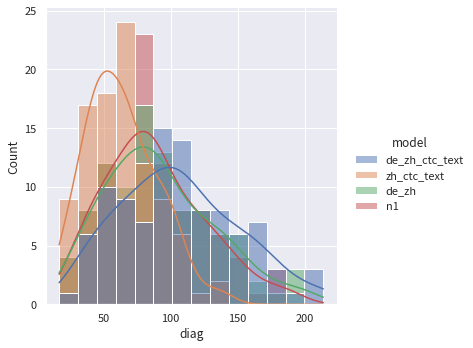

In [113]:
sns.displot(plot_df, x='diag', hue='model', kde=True)

In [100]:
test_st_de_en = load_df_from_tsv('/mnt/raid5/siqi/datasets/covost2/de/test_st_de_en.tsv')
test_de_audios = []
for audio in test_st_de_en['audio']:
    test_de_audios.append(os.path.join('/mnt/raid5/siqi/datasets/covost2/de/16kHz', audio))

In [119]:
idx = 0
audio_id = test_st_de_en['id'][idx]
audio_path = test_de_audios[idx]
text = test_st_de_en['src_text'][idx]
print(text)
grids = textgrids.TextGrid('/mnt/raid5/siqi/datasets/covost2/de/16kHz_test/align/{}.TextGrid'.format(audio_id))

Zieht euch bitte draußen die Schuhe aus.


In [120]:
duration = torchaudio.info(audio_path).num_frames / 16000
intervals = th.tensor([(grid.xmin, grid.xmax) for grid in grids['words'] if grid.text != '']) / duration
tokens = [grid.text for grid in grids['words'] if grid.text != '']

In [124]:
with th.no_grad():
    speech_encoder_out = compute(audio_path)

 83%|████████▎ | 20/24 [00:02<00:00,  7.39it/s]/tmp/ipykernel_8613/2039992068.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=100, figsize=(12, 10))
100%|██████████| 24/24 [00:03<00:00,  7.32it/s]


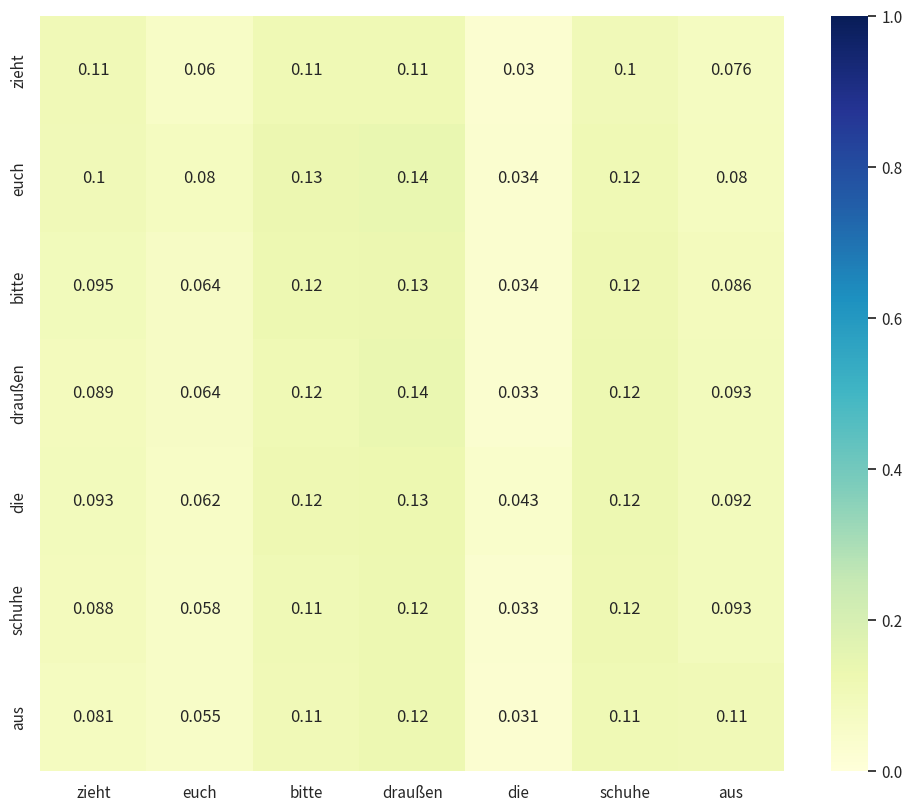

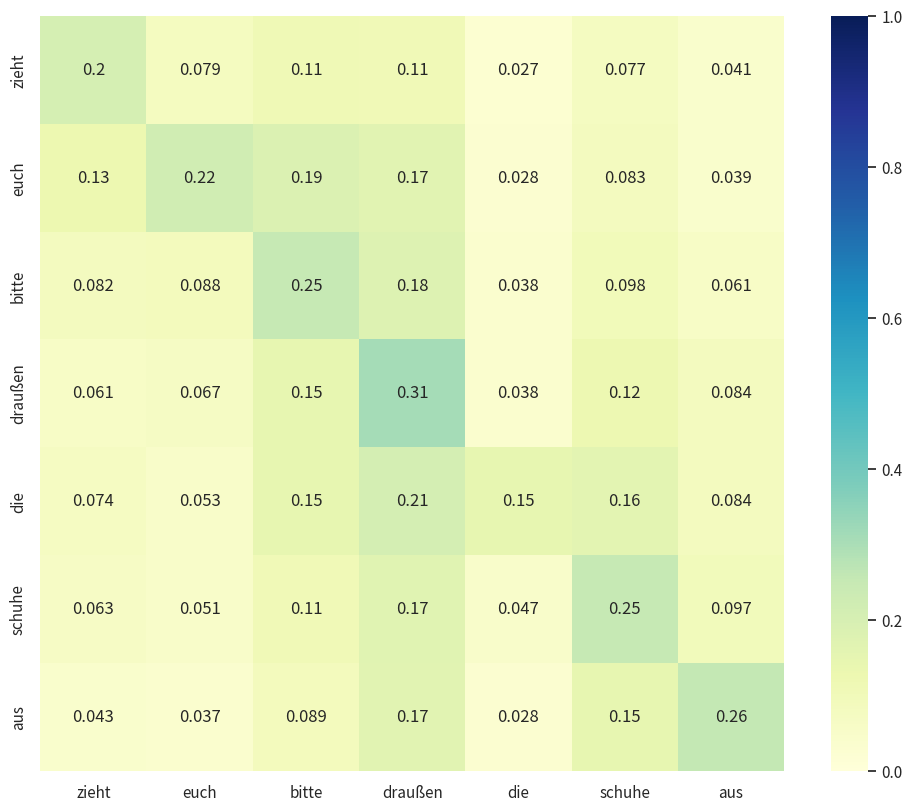

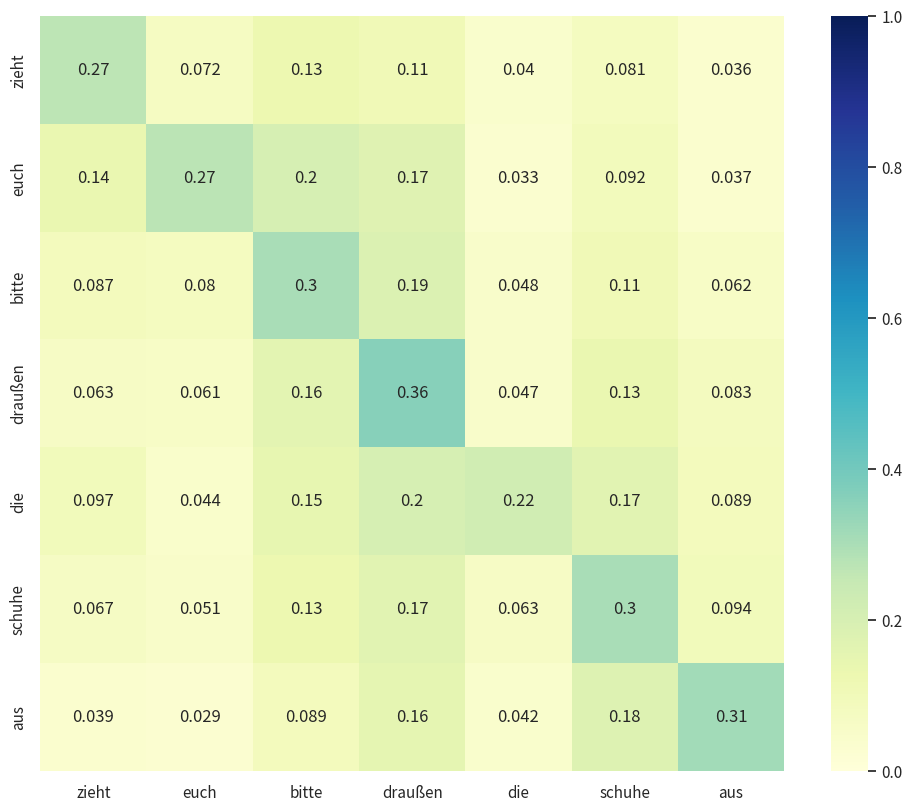

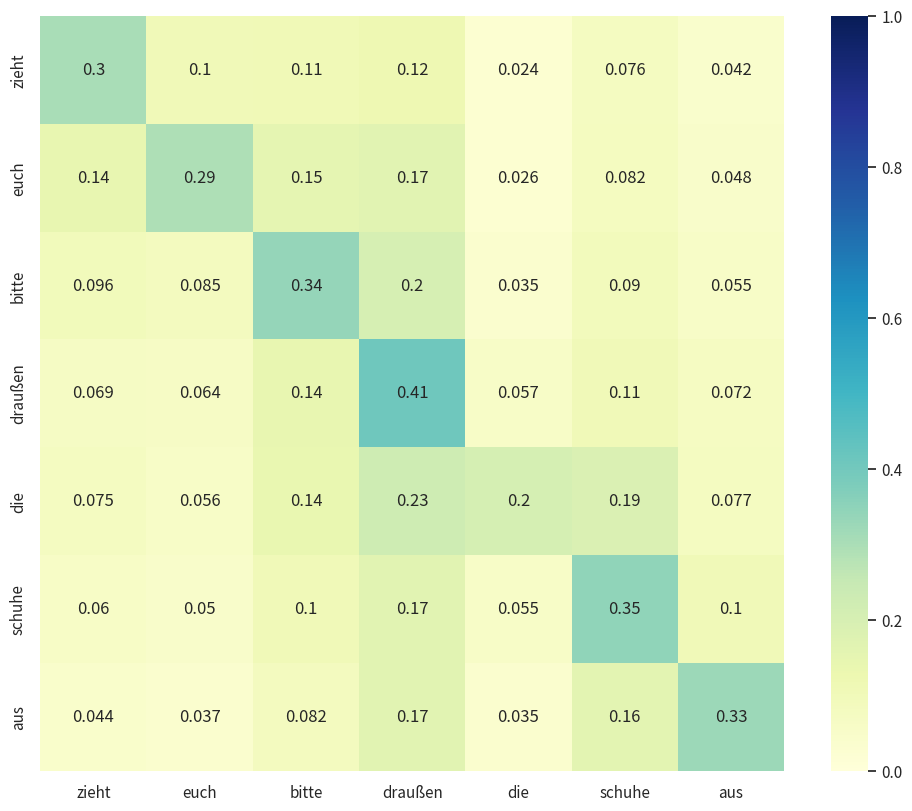

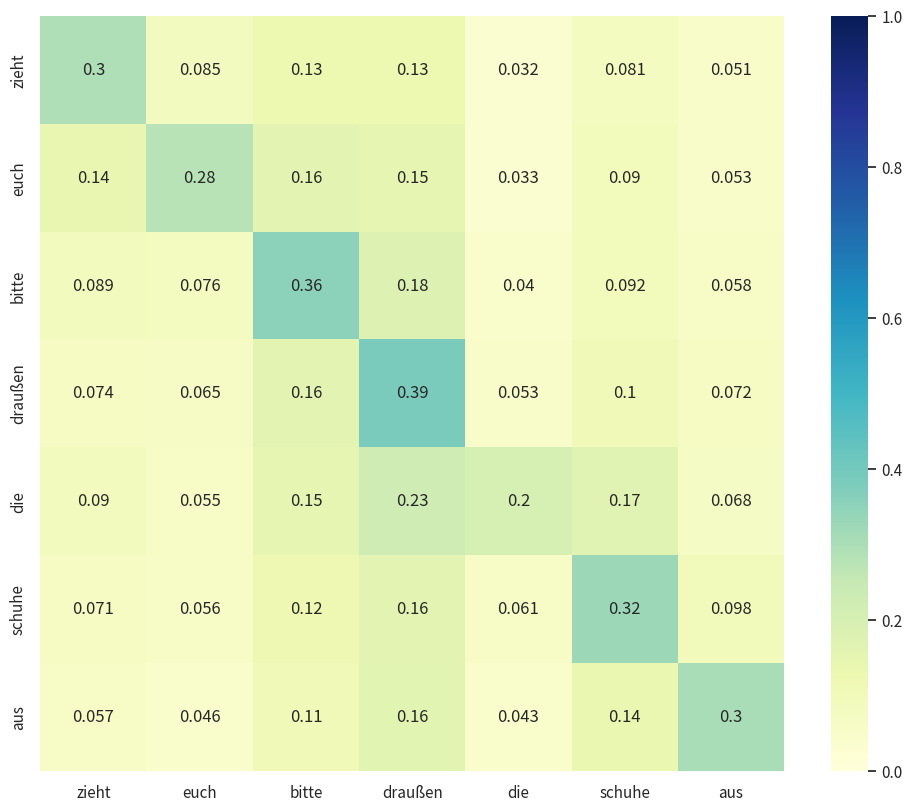

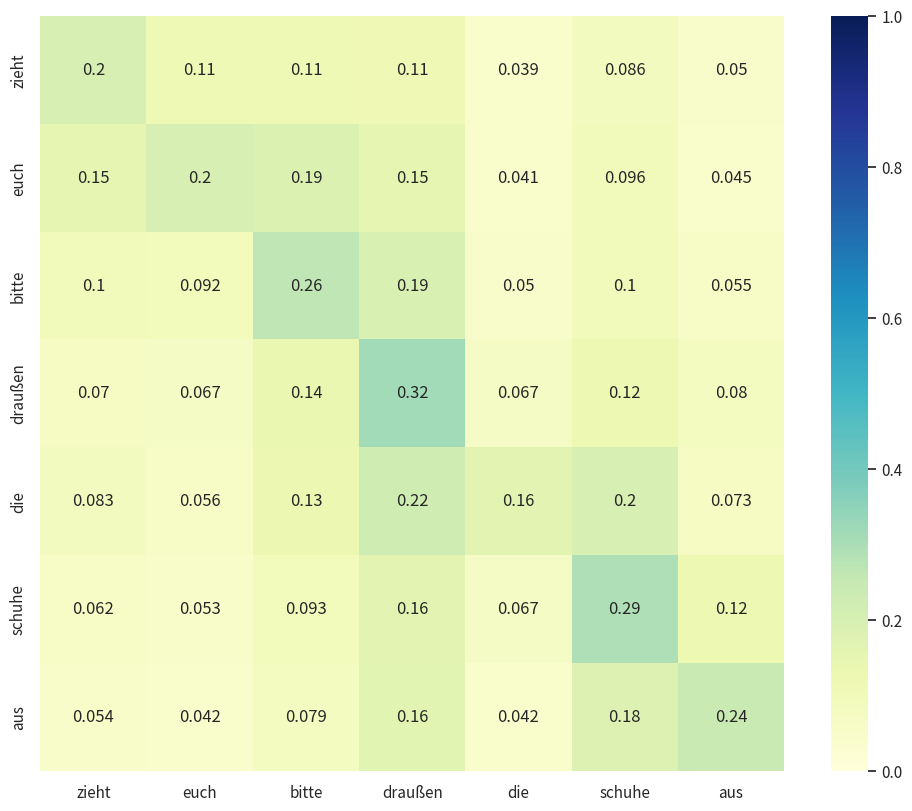

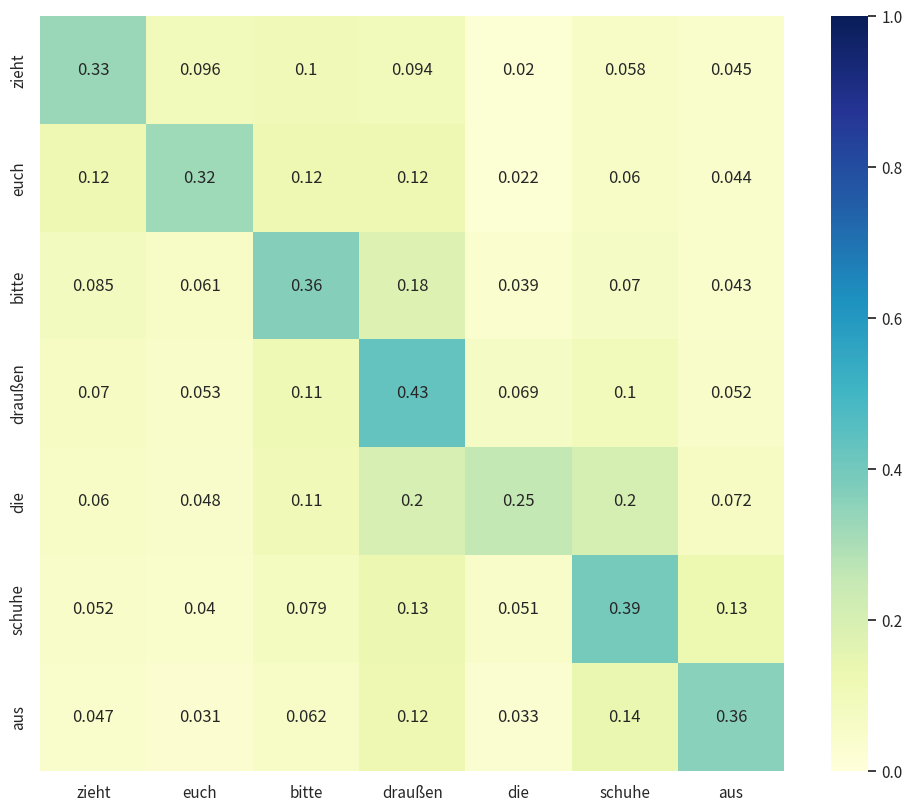

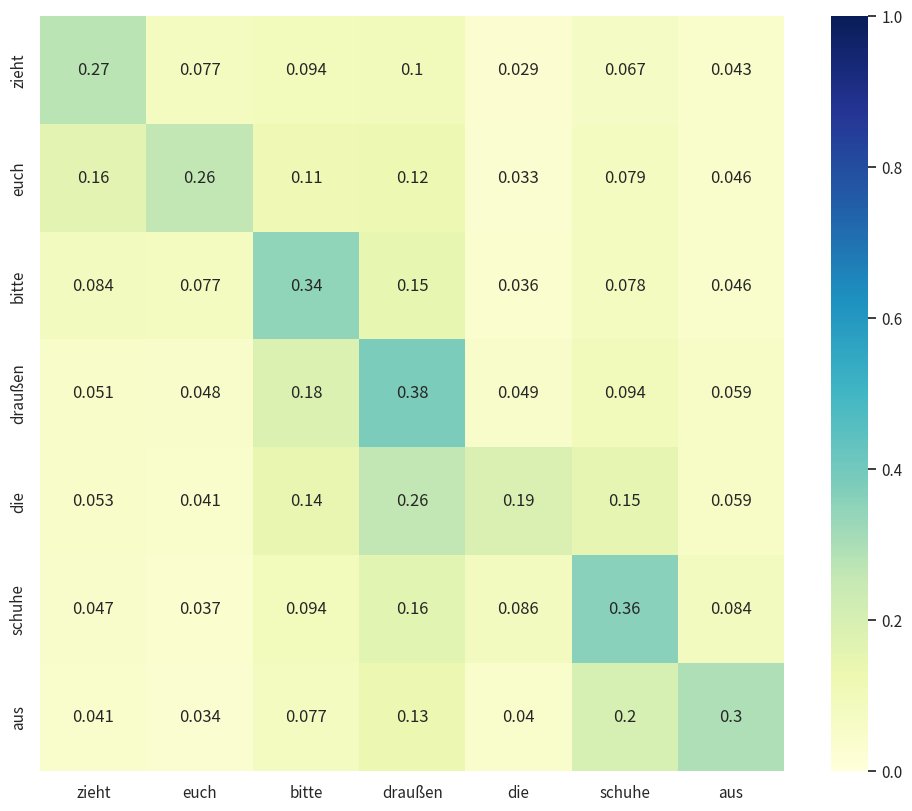

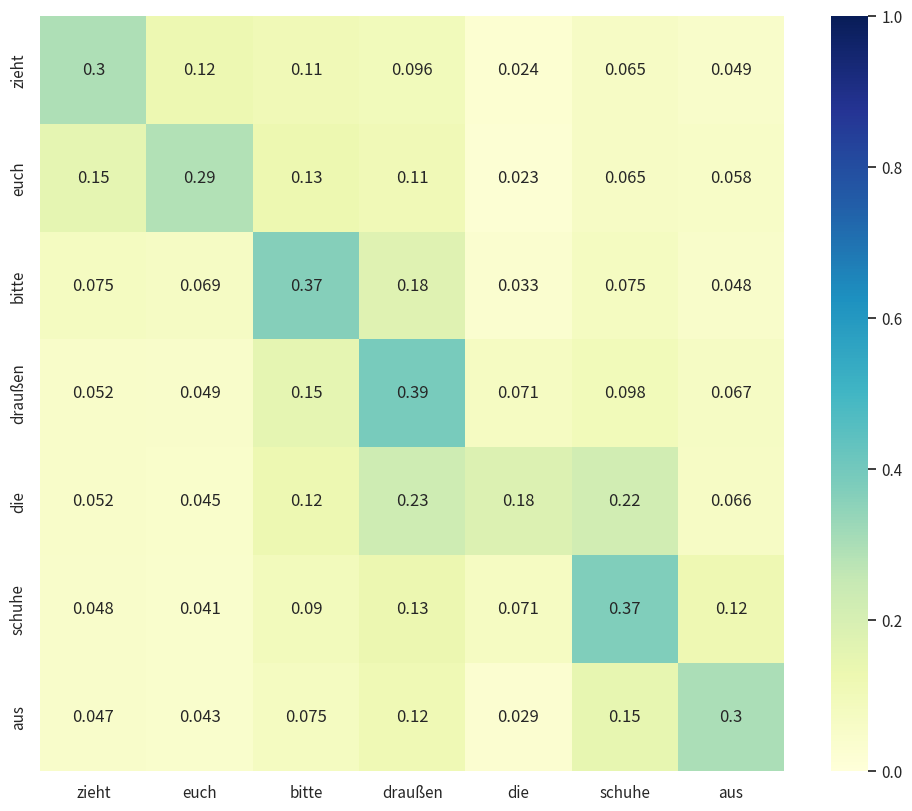

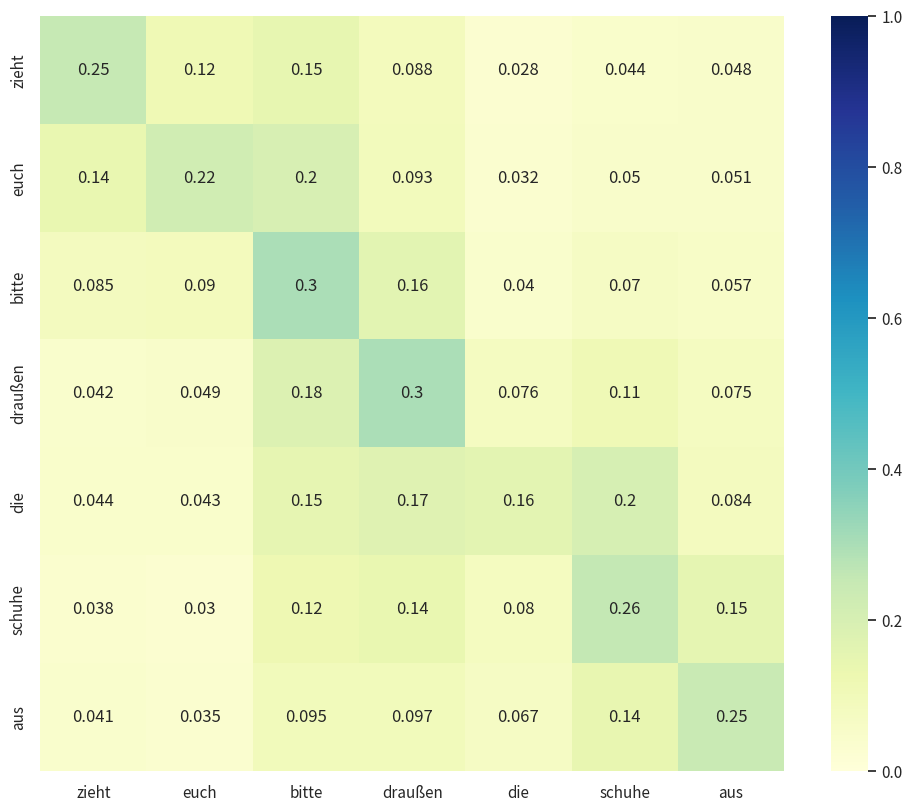

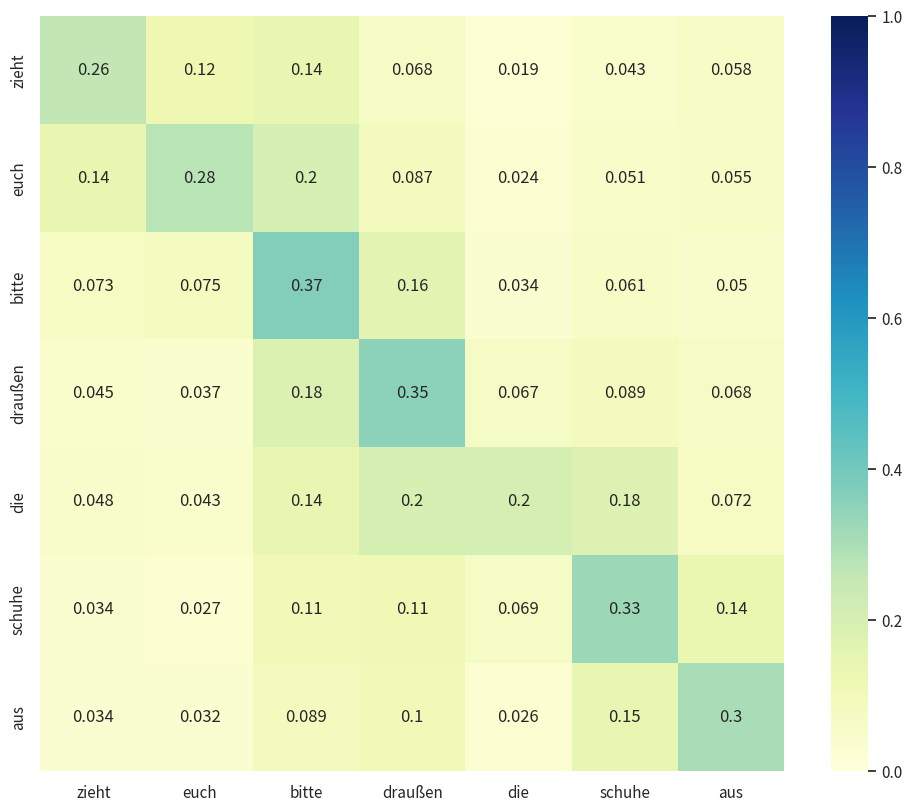

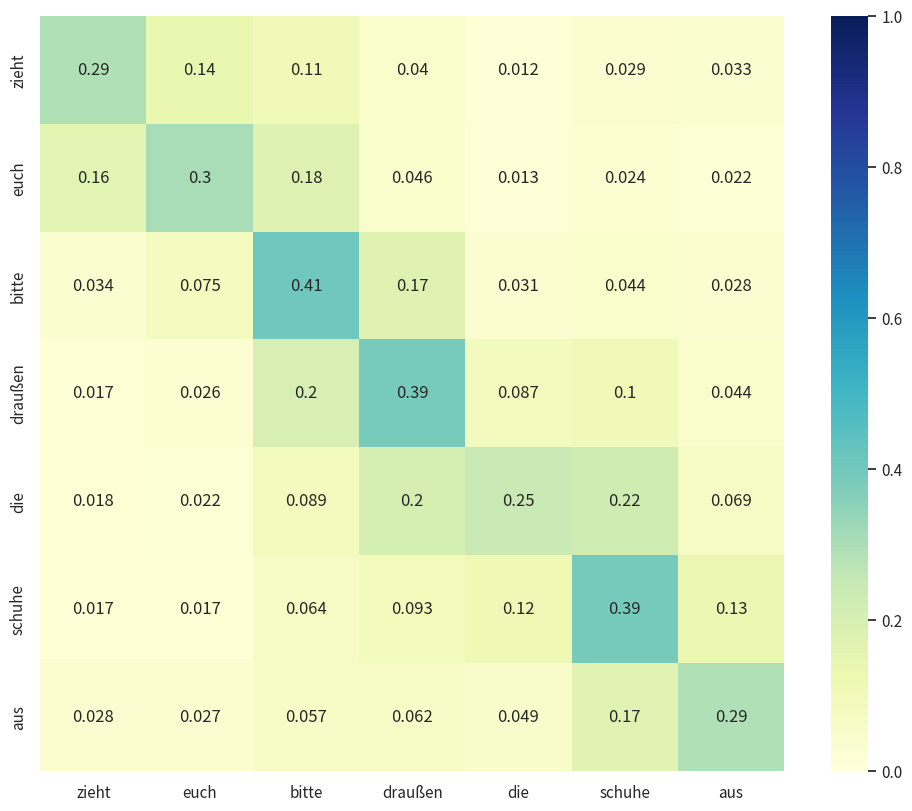

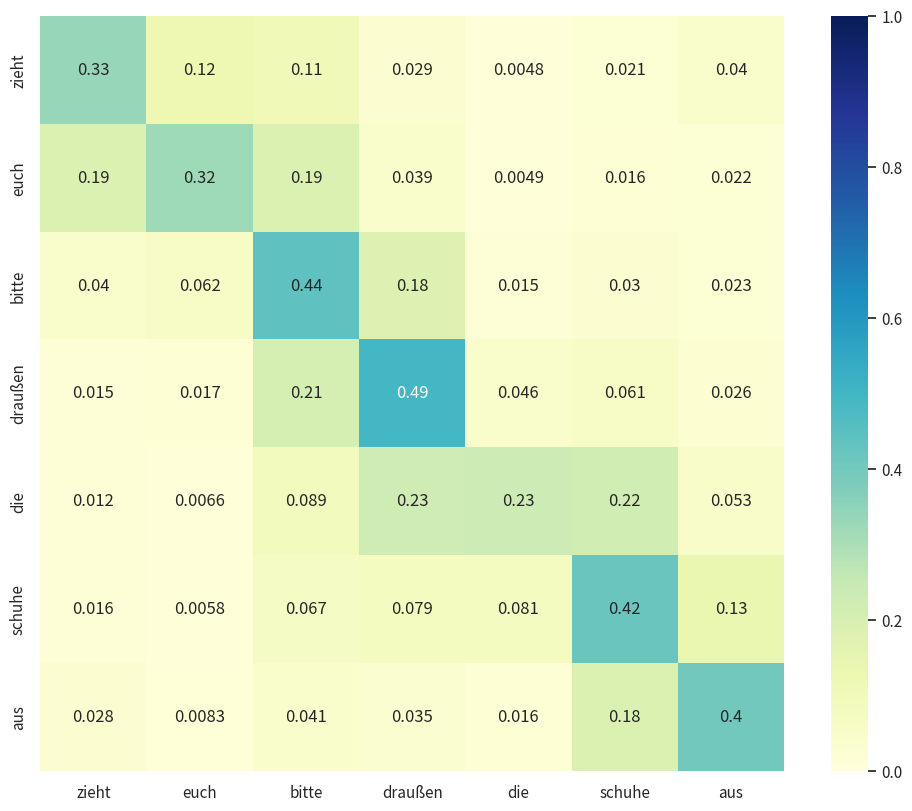

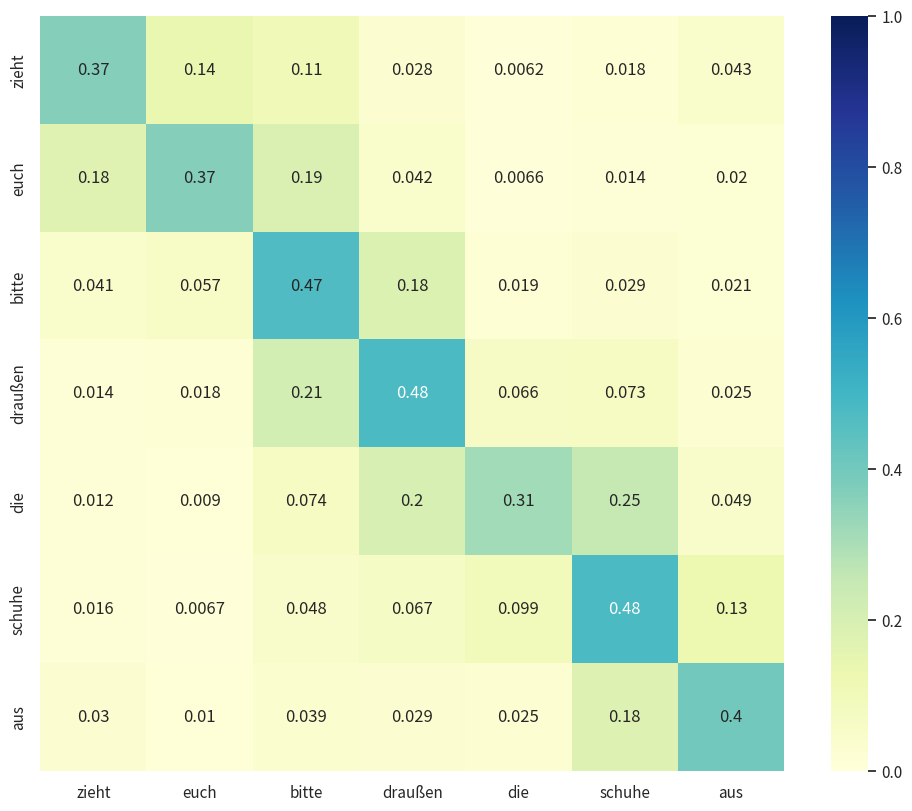

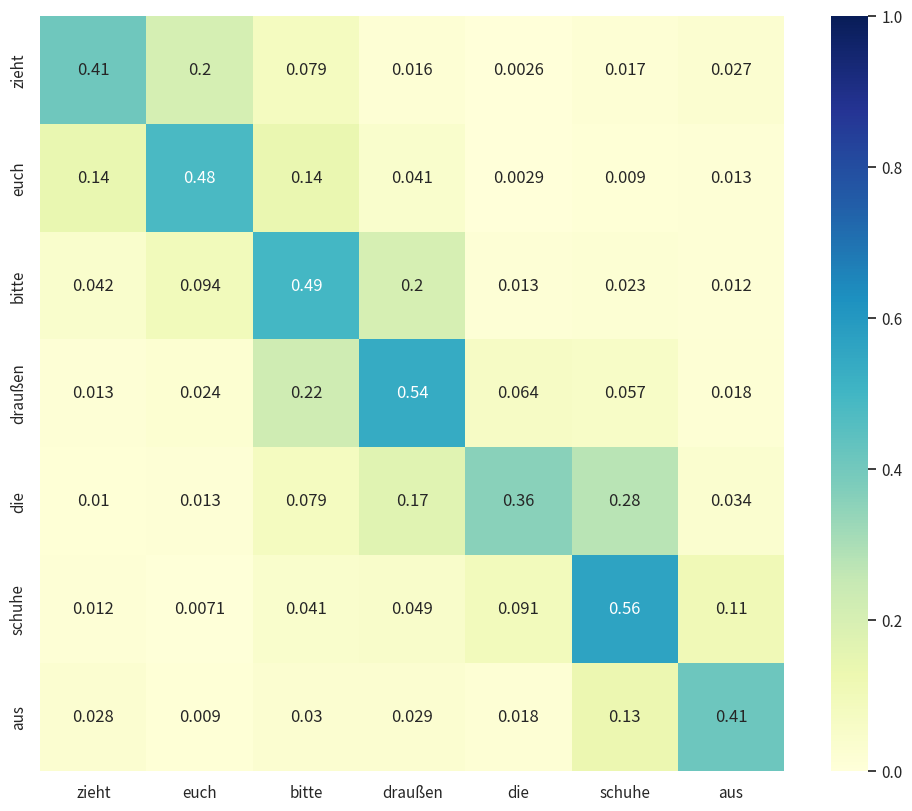

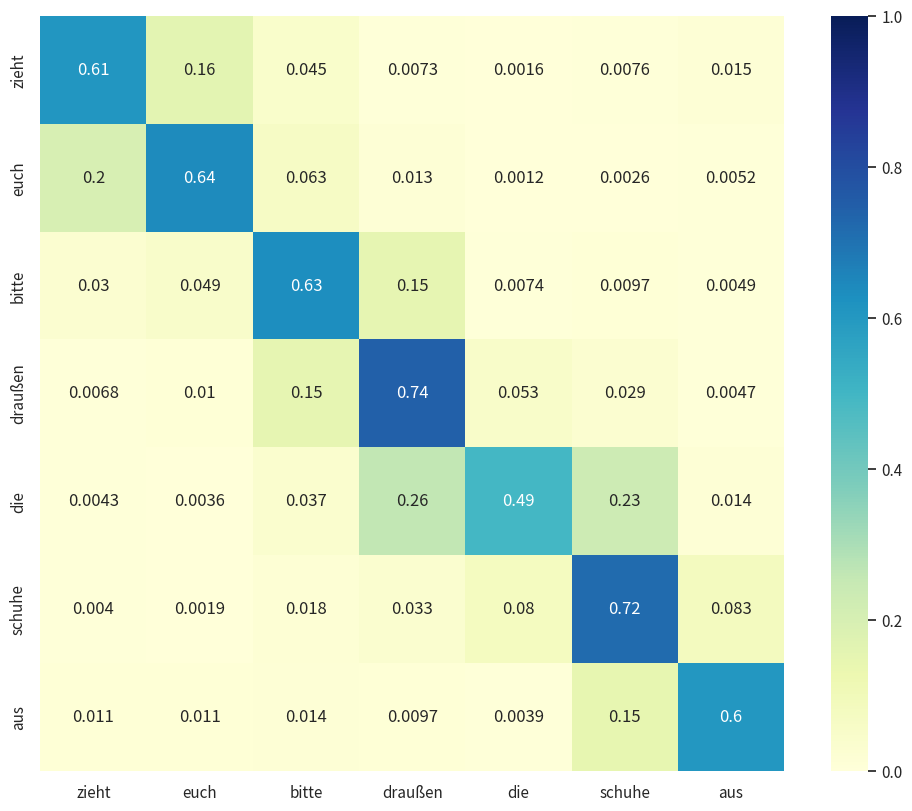

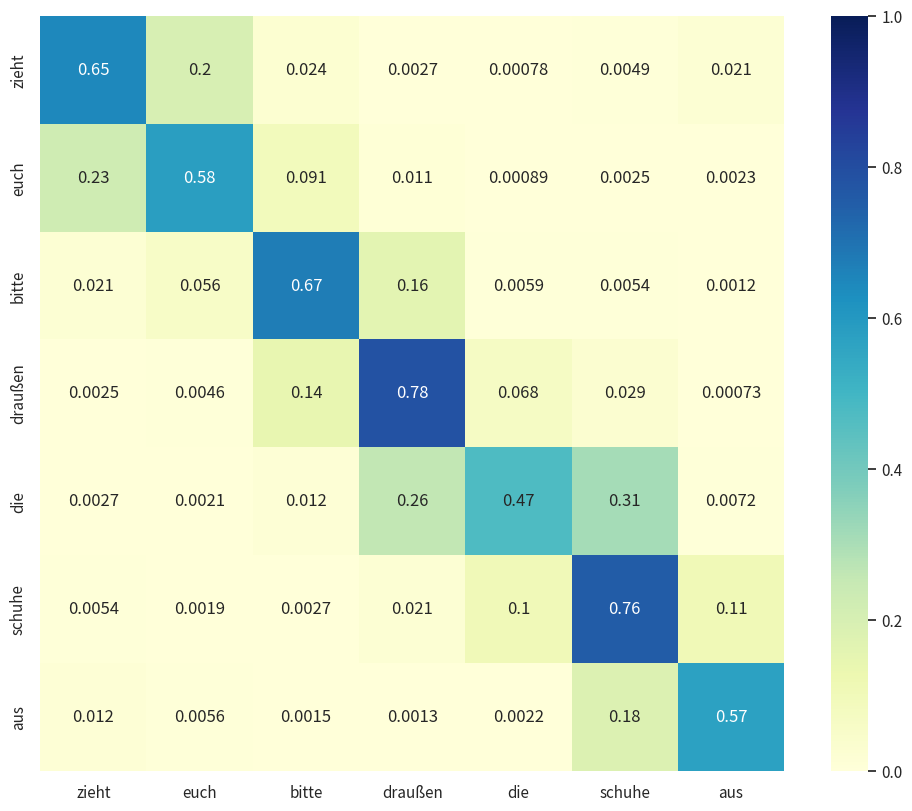

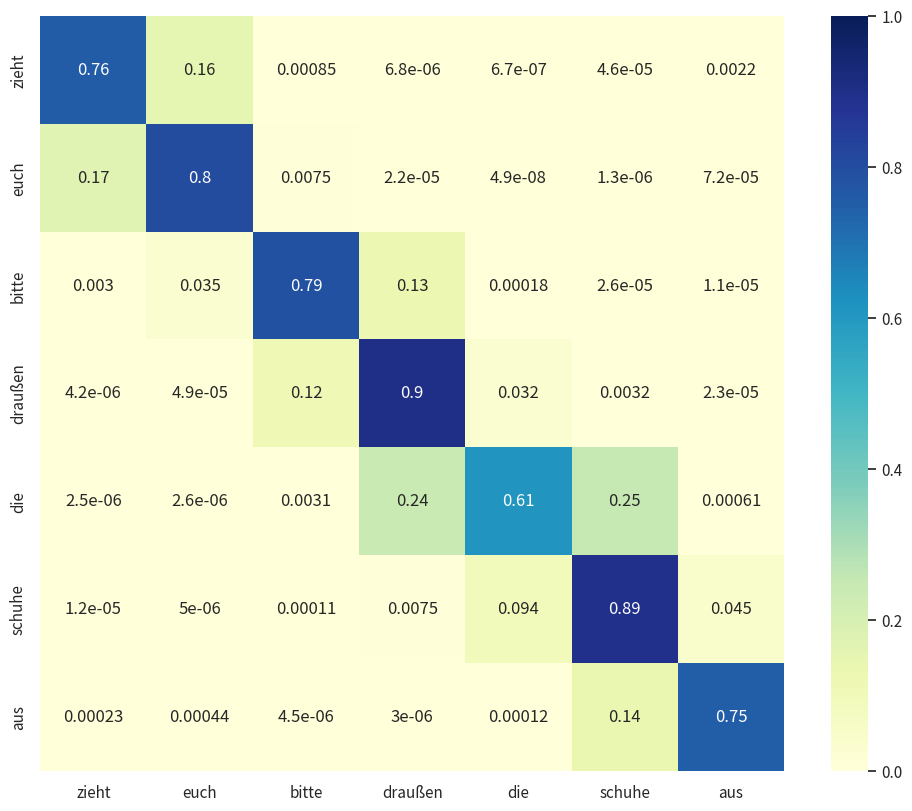

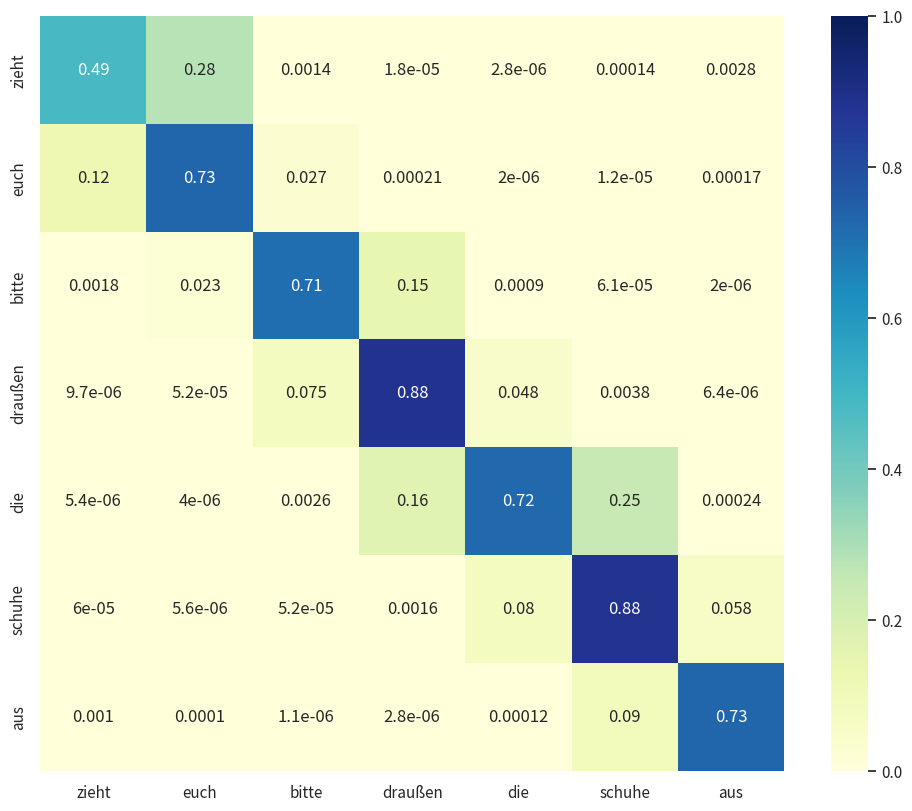

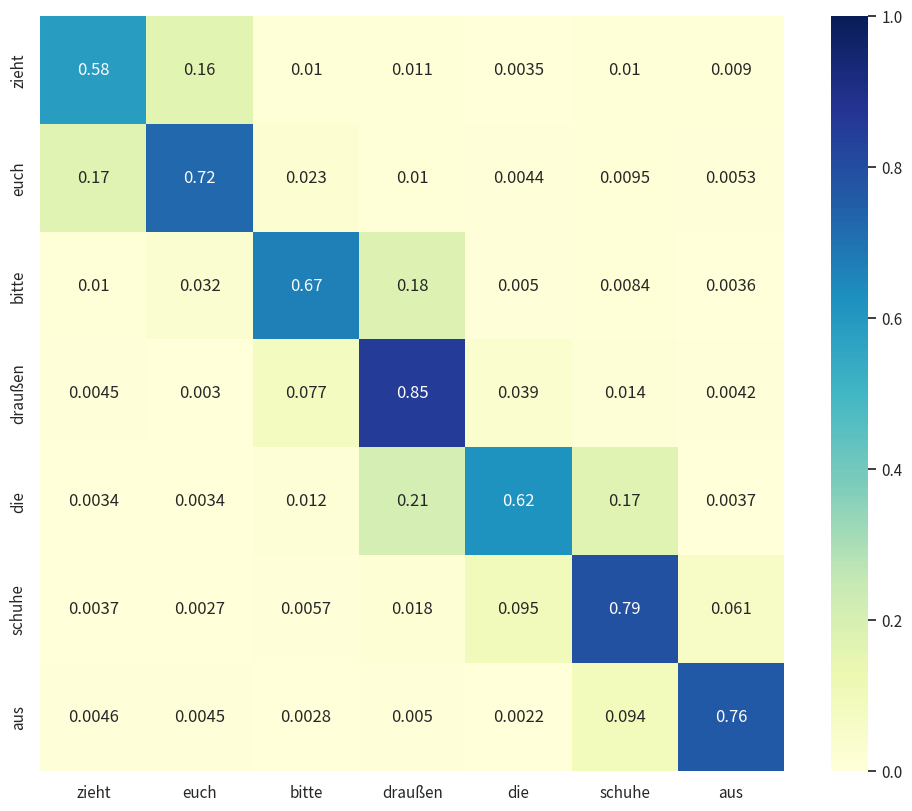

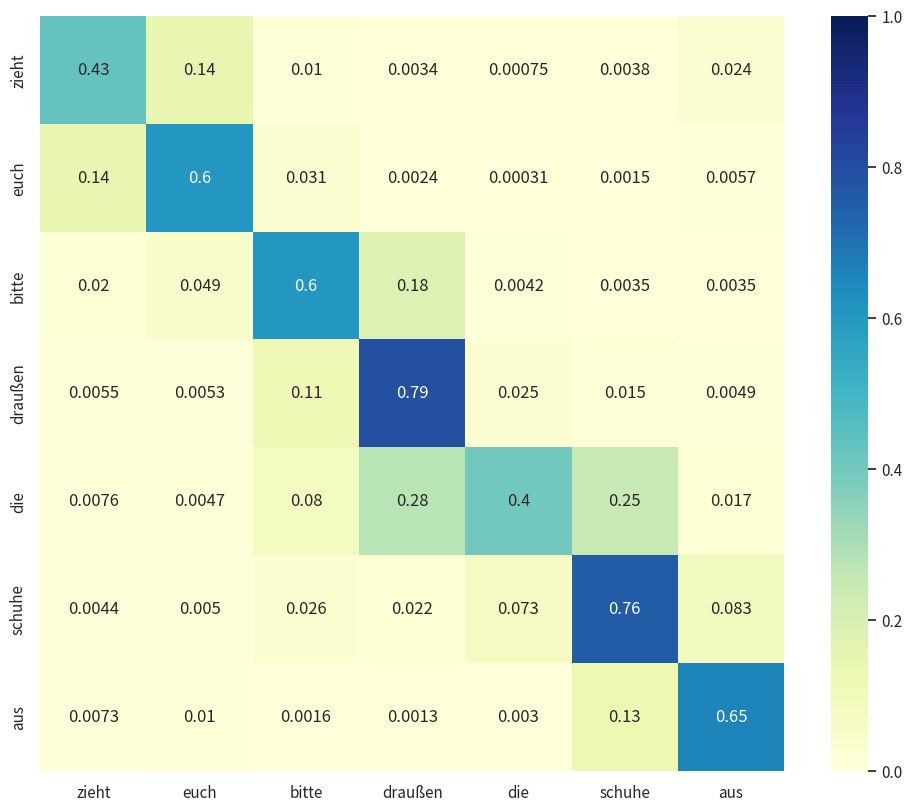

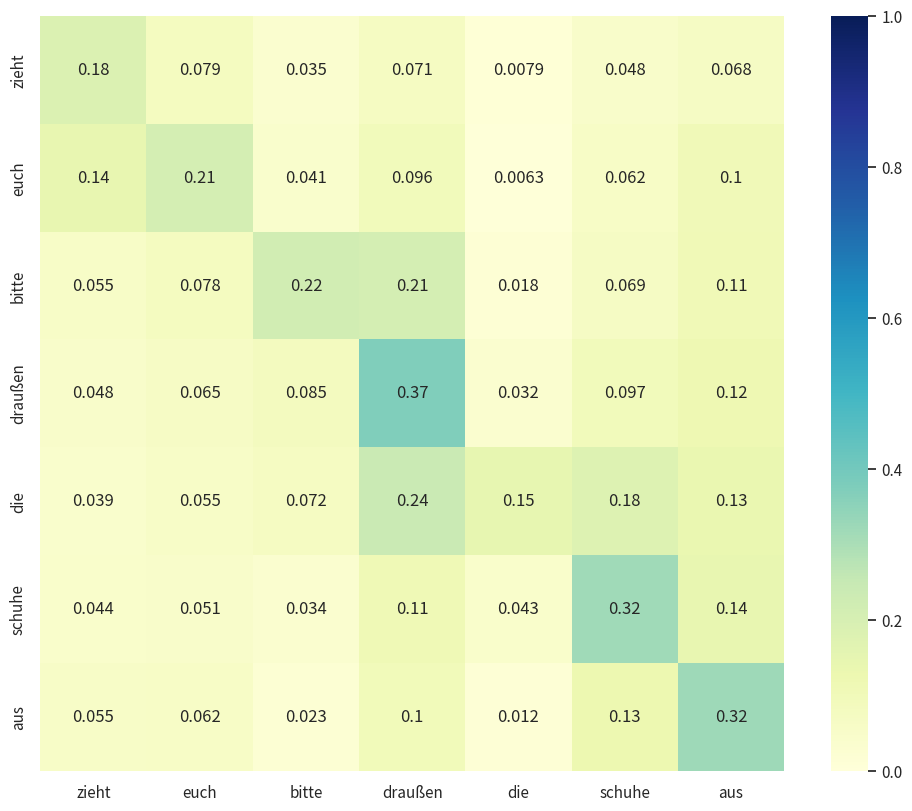

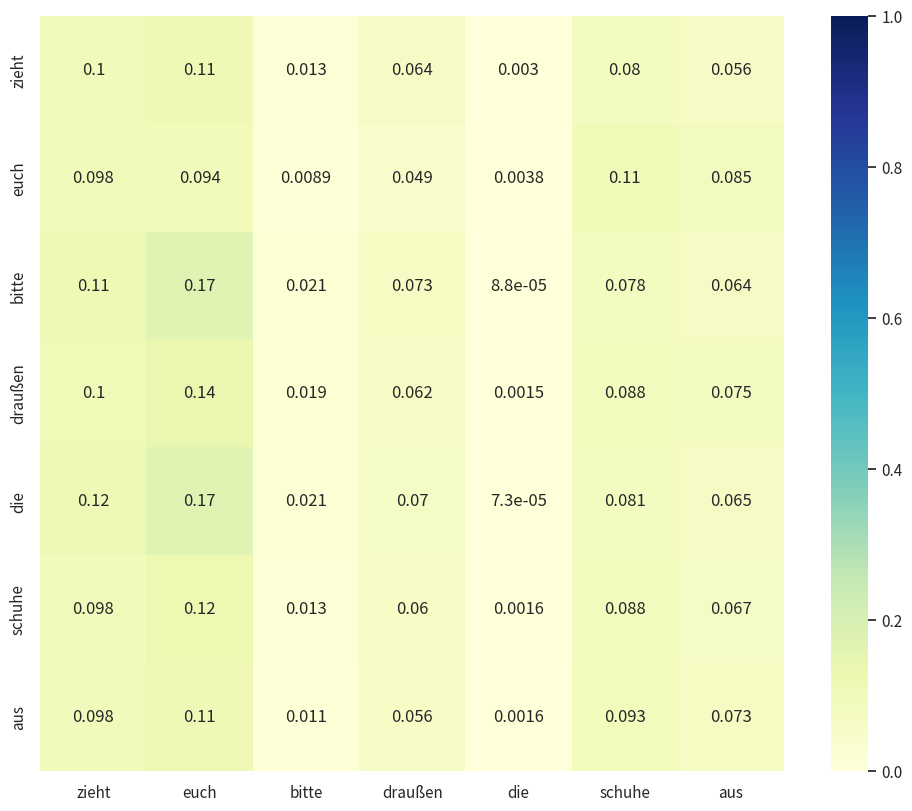

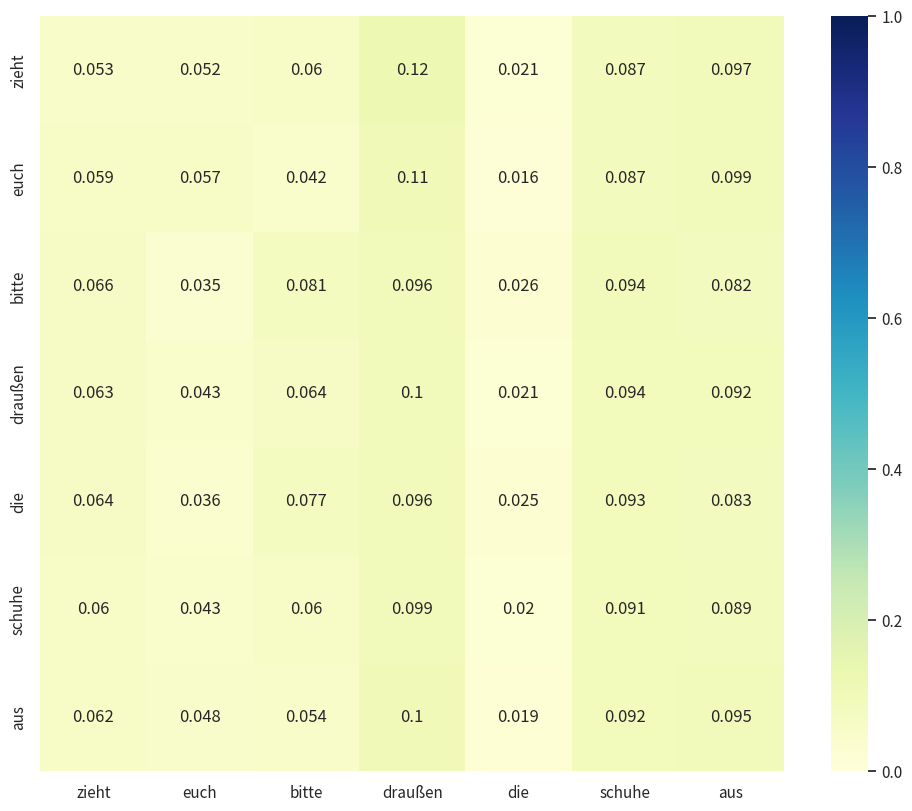

In [107]:
# per layer attn
# os.makedirs('figures/{}'.format(idx), exist_ok=True)
for layer in tqdm(range(24)):
    n_unit = speech_encoder_out['layer_results'][layer][0].size(0)
    unit_intervals = (intervals * n_unit).long()
    attn_matrix = th.zeros(intervals.size(0), intervals.size(0))
    for i, (xmin, xmax) in enumerate(unit_intervals):
        for j, (ymin, ymax) in enumerate(unit_intervals):
            score = speech_encoder_out['layer_results'][layer][0][xmin : xmax + 1, ymin : ymax + 1].sum(dim=1).mean(dim=0)
            attn_matrix[i, j] = score

    plt.figure(dpi=100, figsize=(12, 10))
    sns.heatmap(attn_matrix, xticklabels=tokens, yticklabels=tokens, vmin=0, vmax=1.0, annot=True, cmap="YlGnBu")
    # plt.savefig('figures/{}/de_zh_no_ctc_layer_{}.png'.format(idx, layer))
    # plt.close()

100%|██████████| 24/24 [00:00<00:00, 170.36it/s]


<AxesSubplot:>

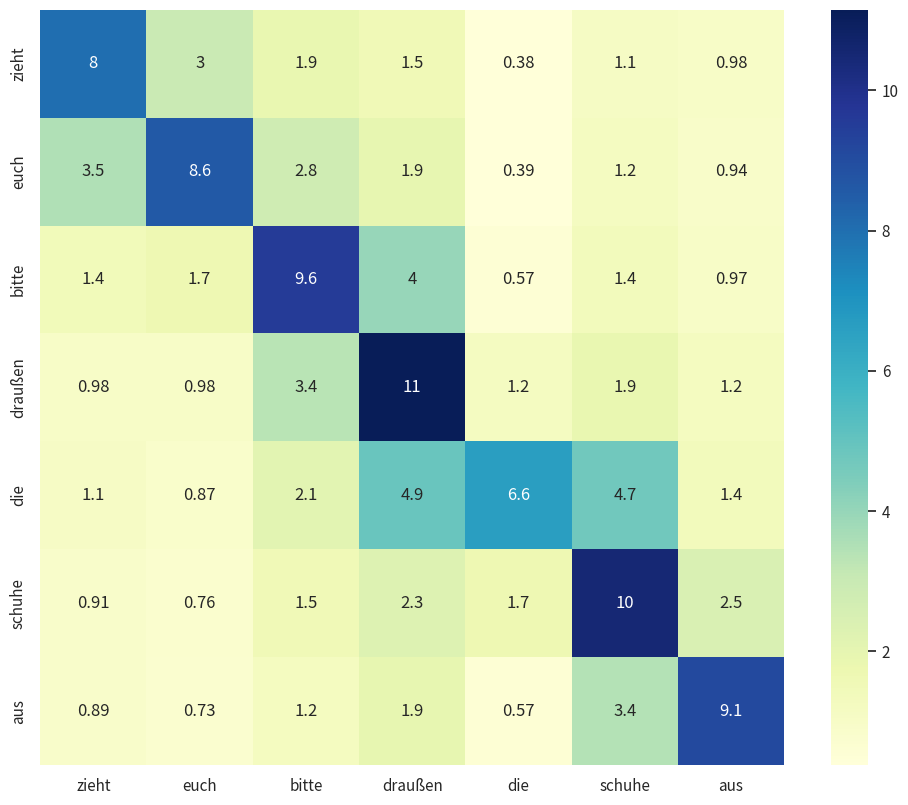

In [125]:
# mean attn over layers
# os.makedirs('figures/{}'.format(idx), exist_ok=True)
attn_matrix = th.zeros(intervals.size(0), intervals.size(0))
for layer in tqdm(range(24)):
    n_unit = speech_encoder_out['layer_results'][layer][0].size(0)
    unit_intervals = (intervals * n_unit).long()
    for i, (xmin, xmax) in enumerate(unit_intervals):
        for j, (ymin, ymax) in enumerate(unit_intervals):
            score = speech_encoder_out['layer_results'][layer][0][xmin : xmax + 1, ymin : ymax + 1].sum(dim=1).mean(dim=0)
            attn_matrix[i, j] += score.item()
plt.figure(dpi=100, figsize=(12, 10))
sns.heatmap(attn_matrix, xticklabels=tokens, yticklabels=tokens, annot=True, cmap="YlGnBu")

100%|██████████| 24/24 [00:00<00:00, 128.59it/s]


<AxesSubplot:>

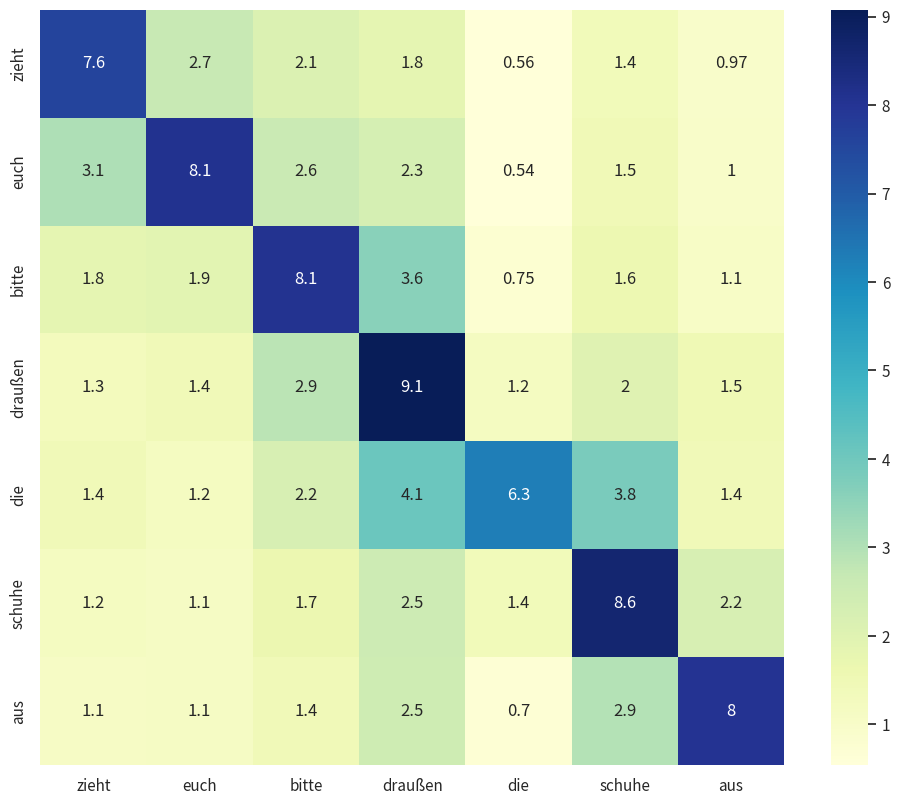

In [72]:
test_st_de_en = load_df_from_tsv('/mnt/raid5/siqi/datasets/covost2/de/test_st_de_en.tsv')

In [99]:
for id, src_text in zip(test_st_de_en['id'][:100], test_st_de_en['src_text']):
    os.system('cp /mnt/raid5/siqi/datasets/covost2/de/16kHz/{}.wav /mnt/raid5/siqi/datasets/covost2/de/16kHz_test/{}.wav'.format(id, id))
    with open('/mnt/raid5/siqi/datasets/covost2/de/16kHz_test/{}.txt'.format(id), 'w') as w:
        w.write(src_text)